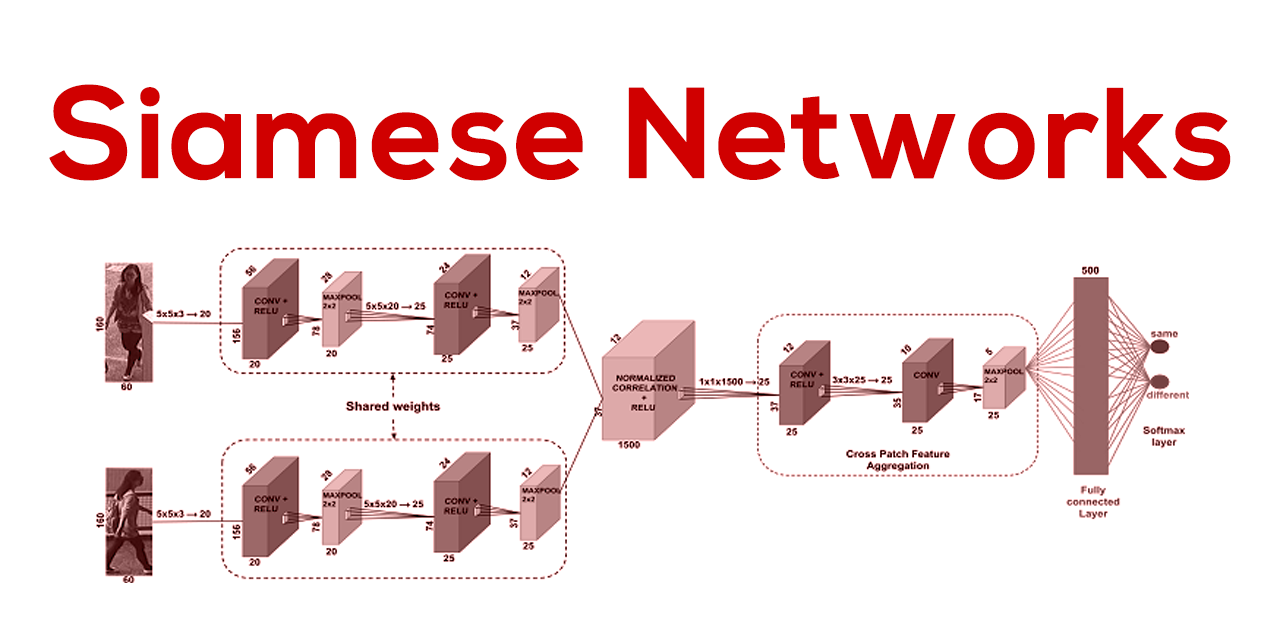

__In the modern Deep learning era, Neural networks are almost good at every task, but these neural networks rely on more data to perform well.But, for certain problems like face recognition and signature verification, we can't always rely on getting more data, to solve this kind of tasks we have a new type of network architecture called saimese networks.__

__It uses only a few numbers of images to get better predictions. The ability to learn from very little data made Saimese networks more popular in recent years.__

# What are Saimese Networks?

**A Saimese Neural Network is a class of neural network architectures that contain two or more identical subnetworks.'identical here means, they have the same configuration with the same parameters and weights.Parameter updating is mirrored across both sub-networks.It is used to find the similarity of the inputs by comparing its feature vectors, so these networks are used in many applications.**

__Traditionally, a neural network learns to predict multiple classes.This poses a problem when we need to add/remove new classes to data.In this case, we have to update the neural network and retrain it on the whole dataset.Also, deep neural network need a large volume of data to train on.SNN's on other hand, learn a siilarity function.Thus, we can train it to see if the two images are the same(which we will do here).This enables us to classify new classes of data without training the network again.__

# Pros andCons of Saimese Networks:

The main advantage of saimese networks are,

- **More Robust to class Imbalance:** With the aid of One-shot learning, given a few images per class is sufficient for Saimese Networks to recognise those images in the future

- **Nice to an ensemble with the best classifier:** Given that its learning mechanism is somewhat different from classification, simple averaging of it with a Classifier can do much better than average 2 correlated Supervised models

- **Learning from semantic similarity:** Saimese focuses n learning embeddings(in deeper layers) that place the same classes/concepts close together.Hence, can learn semantic similarity.

The downsites of the saimese networks are:

- **Need more training time than normal networks:** Since Saimese Networks involves quadratic pairs to learn from (to see all information available) it is slower than normal classification type of learning(pointwise learning)

- **Doesn't output probabilities:** Since training involves pairwise learning, it won't output the probabilities of the prediction, but the distance from each cless

# Model Architecture

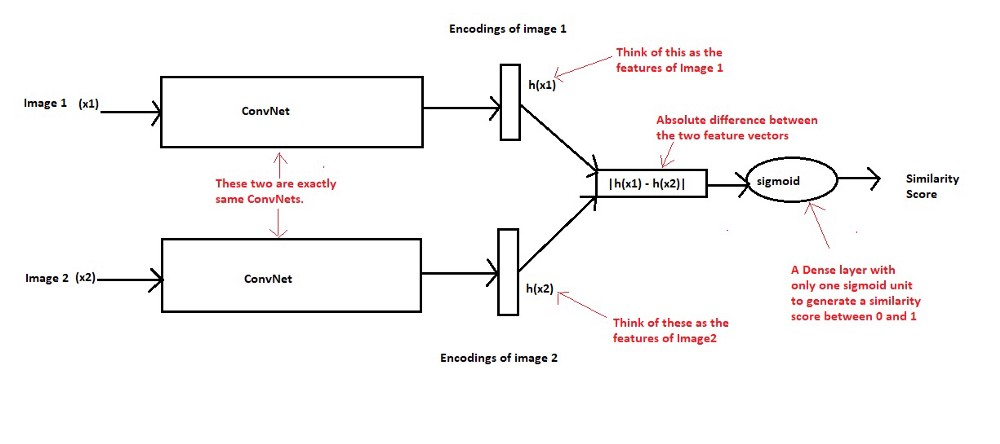

The term Saimese means twins. The two COnvolution Neural Networks are shown above are not different networks but are two copies of the same network, hence the name saimese Networks.Basically they share the same parameters.The two input images(x1 and x2) are passed through the ConvNet to generate a fixed length feature vector for each (h(x1) and h(x2)).Assuming the neural network model is trained properly, we can make the following hypothesis: If the two input images belong to the same character, then thier feature vectors must also be similar, while if the two input images belong to the different characters, then thier feature vectors will also be different.Thus the element-wise absolute difference between the two feature vectors must be very different in both the above cases.And hence the similarity score generated by the output sigmoid layer must also be different in these two cases.This is the central idea behind these networks.

# The Encoder

To do so, it uses an __Encoder__ whose job is to __transform__ the input data into a __Vector of features__. One vector is then created for each input and are passed on to the classifier.When working with images, this encoder will often be a stack of *convolutional layers*, while when working with sequnces, it will often be a stack of RNNs.

# The Classifier

The __classifier__ then **calculates**, from these two inputs, a **distance** value(the distance function can be any distance:L1,L2,..). This **distance** is then __classified__ as being the distance of **similar or dissimilar** data instances:this process is just similar to __findings the right distance value threshold__ above which two data objects are considered dissimilar.

# Training a Saimese Neural Network

Given the definitions of the encoder and the classifier, one may realize that all the difficulty of working with saimese NN lies within the creation process of the vector of features.Indeed, this vector needs the following properties:

- To be **appropriately descriptive** enough so that two **similar** pieces of __data__(with variability) will __have similar vectors__(and hence, small distances)

- To be __discriminative enough__ so that two __dissimilar__ pieces of __data__ will __have dissimilar vectors__.



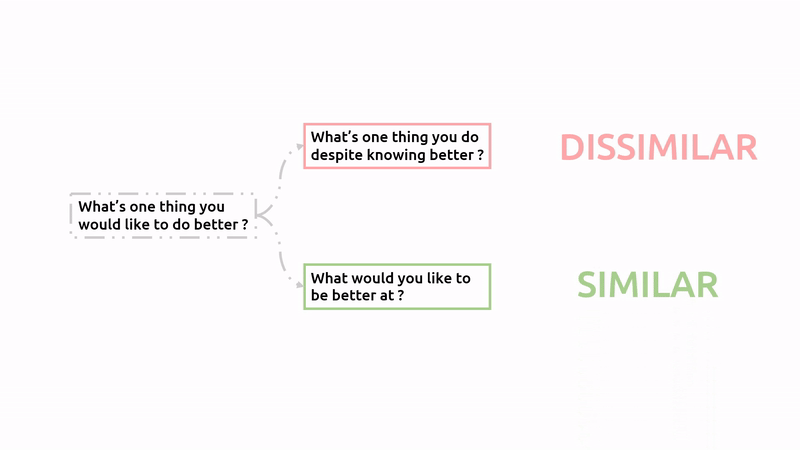

Hence, we see that __training__  this __network__ is all about training it, on one hand, __to recognise similar things__, while on other hand, __to recognise when things are dissimilar:__ both with __good confidence__. It is __not enough__ to __teach__ a model what __two pieces__ of data are, it would overfit to the training data and have a tendency to find everything to be similar (high recall but low precision): it is also about __training__ it to __recognise dissimilar data__(and thus, balance its recall and precision) and ultimately, what makes two pieces of data inherently different.

# Losses for Deep Similarity Learning

### Contrastive Loss

when training a Saimese Network with a contrastive loss, it will take __two inputs data__ to compare __at each time step.__ These two input data could be either be similar or dissimilar.This is modelled by a binary class variable Y whose values are:
- 0 if dissimilar
- 1 if similar

These classes can obviously be changed, to the conditions that the loss function is adapted.

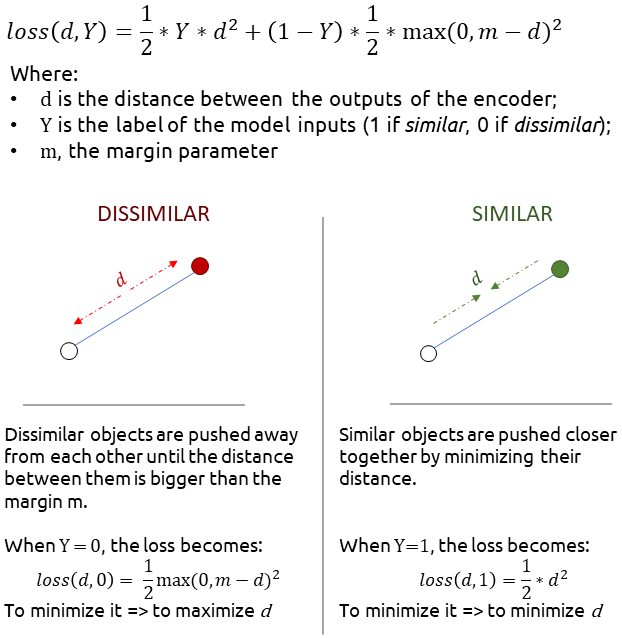

In [1]:
import keras
import tensorflow as tf
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.layers import Conv2D, Activation, AveragePooling2D
from keras import backend as K

In [2]:
num_classes = 10
epochs = 20

In [3]:
def euclid_dis(vects):
    x,y = vects
    sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [4]:
def contrastive_loss(y_true, y_pred):
    y_true = tf.dtypes.cast(y_true, tf.float64)
    y_pred = tf.dtypes.cast(y_pred, tf.float64)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1-y_true) * margin_square)


In [5]:
def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    
    n=min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    
    for d in range(num_classes):
        for i in range(n):
            z1,z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1,z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1,0]
        return np.array(pairs), np.array(labels)

In [16]:
def create_base_network(input_shape):
    
    input = Input(shape=input_shape)
    x = Conv2D(4, (5,5), activation='tanh')(input)
    x = AveragePooling2D(pool_size=(2,2))(x)
    x = Conv2D(16, (5,5), activation = 'tanh')(x)
    x = AveragePooling2D(pool_size = (2,2))(x)
    x = Flatten()(x)
    x = Dense(10, activation = 'tanh')(x)
    model = Model(input, x)
    model.summary()
    
    return model

In [17]:
def compute_accuracy(y_true, y_pred):
    '''
    compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''computes classification accuracy '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [18]:
# the data , split between the train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)
input_shape=(1,28,28)
print(x_train.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
x_train /= 255
x_test /= 255

input_shape = x_train.shape[1:]
input_shape = (28, 28, 1)

(60000, 28, 28, 1)


In [19]:
#Creating test+train positive and negitive pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 4)         104       
_________________________________________________________________
average_pooling2d_1 (Average (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 16)          1616      
_________________________________________________________________
average_pooling2d_2 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2570  

In [20]:
input_a = Input(shape = input_shape)
input_b = Input(shape = input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclid_dis, output_shape = eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

model.compile(loss = contrastive_loss, optimizer='adam', metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
         batch_size=128,
         epochs=epochs,
         validation_data=([te_pairs[:,0], te_pairs[:,1]], te_y))

Epoch 1/20
85/85 [==============================] - 14s 165ms/step - loss: 0.0749 - accuracy: 0.9239 - val_loss: 0.0325 - val_accuracy: 0.9838
Epoch 2/20
85/85 [==============================] - 14s 163ms/step - loss: 0.0371 - accuracy: 0.9709 - val_loss: 0.0240 - val_accuracy: 0.9849
Epoch 3/20
85/85 [==============================] - 14s 163ms/step - loss: 0.0268 - accuracy: 0.9784 - val_loss: 0.0198 - val_accuracy: 0.9849
Epoch 4/20
85/85 [==============================] - 14s 161ms/step - loss: 0.0201 - accuracy: 0.9833 - val_loss: 0.0148 - val_accuracy: 0.9866
Epoch 5/20
85/85 [==============================] - 14s 169ms/step - loss: 0.0163 - accuracy: 0.9849 - val_loss: 0.0132 - val_accuracy: 0.9860
Epoch 6/20
85/85 [==============================] - 13s 157ms/step - loss: 0.0131 - accuracy: 0.9865 - val_loss: 0.0112 - val_accuracy: 0.9894
Epoch 7/20
85/85 [==============================] - 13s 156ms/step - loss: 0.0110 - accuracy: 0.9887 - val_loss: 0.0119 - val_accuracy: 0.9894

In [21]:
#computing the final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:,0], te_pairs[:,1]])
te_acc = compute_accuracy(te_y, y_pred)

print(' * Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print(' * Accuracy on test set: %0.2f%%' % (100 * te_acc))

 * Accuracy on training set: 99.66%
 * Accuracy on test set: 99.16%


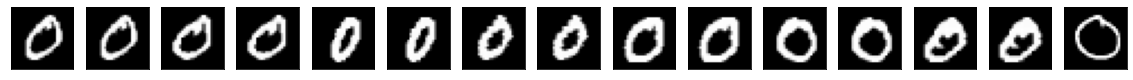

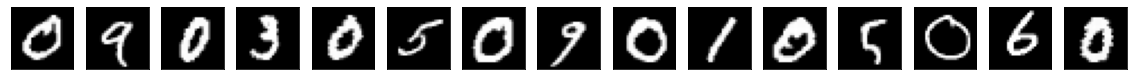

[0.00638447]
[0.92471683]
[0.00920989]
[3.3440604]
[0.00500452]
[1.7615491]
[0.00537277]
[2.608545]
[0.0120059]
[2.0453432]
[0.01442181]
[2.331493]
[0.00884541]
[2.7313488]
[0.00747501]


In [22]:
import matplotlib.pyplot as plt
from PIL import Image
number_of_items = 15

im = keras.preprocessing.image.array_to_img(tr_pairs[1,0],
                                           data_format=None,
                                           scale=True,
                                           dtype=None)

plt.figure(figsize=(20,10))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items, item+1)
    im = keras.preprocessing.image.array_to_img( tr_pairs[item,0], data_format=None,scale=True, dtype=None)
    plt.imshow(im, cmap='gray')
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20,10))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = keras.preprocessing.image.array_to_img( tr_pairs[item,1], data_format=None, scale=True, dtype=None)
    plt.imshow(im, cmap='gray')
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

for i in range(number_of_items):
    print(y_pred[i])